## Library

In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=e485d0d1153be2489eab0fc56e52d160f9906a7a3603c81cfb08d7f6c5d80ccc
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 4.0 MB

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/classification

/content/drive/MyDrive/classification


In [ ]:
from transformers import AutoModelForSequenceClassification,Trainer,AutoTokenizer,TrainingArguments
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score
from sklearn.model_selection import train_test_split

## Data pre-processing

In [ ]:
#Importing into the database, 'dataset = 1' represents the tweet dataset, 2 stands for the Kaggle dataset, and 3 for the liar dataset

dataset = "2"

if dataset == "1":

    df = pd.read_excel("Constraint_Train.xlsx")
    test_df  = pd.read_excel("Constraint_Test.xlsx")

elif dataset == "2":

    #df = pd.read_excel("texts_labeled_cleaned.xlsx")
    df = pd.read_excel("./BERT/BERT/2/texts_labeled_cleaned.xlsx")

    df.columns = ["tweet","label"]


    df,test_df = train_test_split(df,test_size=0.1,random_state=12)

elif dataset == "3":

    train = pd.read_csv('train.csv',delimiter='\t')
    test = pd.read_csv('test.csv',delimiter='\t')
    valid = pd.read_csv('valid.csv',delimiter='\t')

    replace_dict = {'half-true': 0, 'mostly-true': 0, 'false': 0, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

    train['false'] = train['false'].replace(replace_dict)

    test['true'] = test['true'].replace(replace_dict)

    valid['barely-true'] = valid['barely-true'].replace(replace_dict)

    value_counts = train['false'].value_counts()

    label_train = train['false'].tolist()
    label_test = test['true'].tolist()
    train_set = train['Says the Annies List political group supports third-trimester abortions on demand.'].tolist()
    test_set = test['Building a wall on the U.S.-Mexico border will take literally years.'].tolist()
    unlabeled = valid['We have less Americans working now than in the 70s.'].tolist()
    df = pd.DataFrame({"tweet" : train_set + test_set,
              "label" : label_train + label_test })

    test_df = pd.DataFrame({"tweet" : unlabeled} )


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform( df['label'] )

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy" : accuracy_score(labels,predictions),
            "f1"  : f1_score(labels,predictions),
            "precision"  : precision_score(labels,predictions)}

## BERT classifier

In [ ]:
#Using the BERT model to extract feature information from the news data.

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

id2label = {0 : 0 ,1 : 1}
label2id = {0 : 0, 1 : 1}

model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=2, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state=12)

In [ ]:
train_encoding =  tokenizer(train_df['tweet'].values.tolist(), truncation=True, padding=True)
val_encoding   = tokenizer(val_df['tweet'].values.tolist(), truncation=True, padding=True)
train_dataset = TextDataset(train_encoding,train_df['label'].values.tolist())
val_dataset   = TextDataset(val_encoding,val_df['label'].values.tolist())

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision
1,No log,0.591548,0.681818,0.588235,0.784314
2,No log,0.539556,0.772727,0.753086,0.792208


TrainOutput(global_step=88, training_loss=0.5957945910367098, metrics={'train_runtime': 44.4811, 'train_samples_per_second': 31.564, 'train_steps_per_second': 1.978, 'total_flos': 369407921725440.0, 'train_loss': 0.5957945910367098, 'epoch': 2.0})

## Embedding

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(model_name)

In [ ]:
train_embedding = model.encode(train_df["tweet"].values.tolist())
val_embedding   = model.encode(val_df["tweet"].values.tolist())

In [ ]:
train_embedding.shape

(702, 768)

In [ ]:
val_embedding.shape

(176, 768)

In [ ]:
train_label = train_df["label"].tolist()
val_label   = val_df["label"].tolist()

## classical classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

In [ ]:
def compute_metrics(model_name,predict,true):
    return {
        "model_name" : model_name,
        "accuracy" : accuracy_score(true,predict),
        "f1" : f1_score(true,predict),
        "precision" : precision_score(true,predict)
    }

In [ ]:
models = [KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,MLPClassifier]
result = []
for m in models:
    model = m()
    model.fit(train_embedding,
              train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics(m.__name__,
                                  val_predict,
                                  val_label))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
print("dataset:",dataset)

pd.DataFrame(result)

dataset: 2


,model_name,accuracy,f1,precision
0,KNeighborsClassifier,0.585227,0.546584,0.578947
1,LogisticRegression,0.795455,0.800000,0.757895
2,DecisionTreeClassifier,0.653409,0.643275,0.639535
3,MLPClassifier,0.755682,0.767568,0.710000


## KNN method

In [ ]:
#test different k values
from tqdm.auto import tqdm

Ks = [1,2,3,4,5,6,7,8,9,10,20,30]

result = []

for k in tqdm(Ks):
    model = KNeighborsClassifier(n_neighbors=k)

    model.fit(train_embedding,train_label)

    val_predict = model.predict(val_embedding)

    result.append(compute_metrics("{}".format(k),
                                  val_predict,
                                  val_label))


  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
knndf = pd.DataFrame(result)

knndf.columns = ["K","accuracy","f1","precision"]
knndf.index = knndf.K

knndf = knndf.drop(columns = ["K"])
knndf

,accuracy,f1,precision
K,,,
1,0.517045,0.525140,0.500000
2,0.482955,0.235294,0.411765
3,0.539773,0.520710,0.523810
4,0.562500,0.429630,0.580000
5,0.585227,0.546584,0.578947
6,0.590909,0.485714,0.618182
7,0.630682,0.619883,0.616279
8,0.602273,0.539474,0.611940
9,0.585227,0.587571,0.565217


<Axes: xlabel='K'>

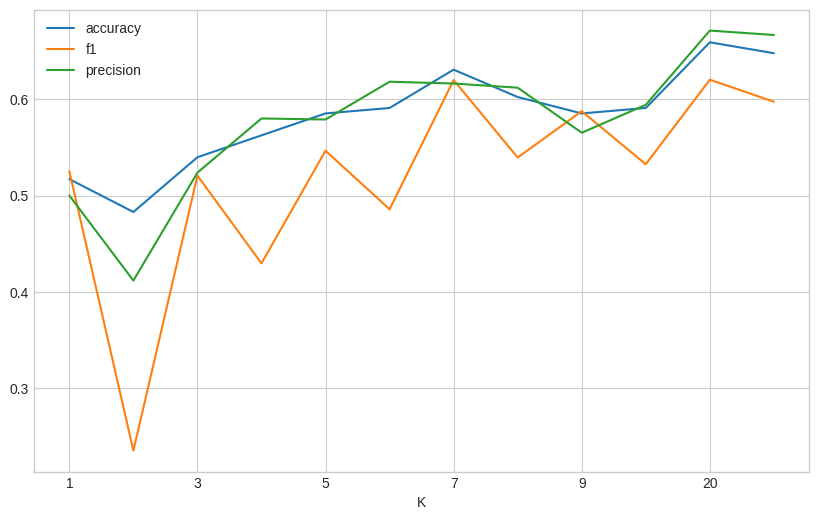

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

fig,ax = plt.subplots(1,1,figsize=(10,6))
knndf.plot(ax = ax)

## CNN realization

In [ ]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.float32).unsqueeze(1)

In [ ]:
class FakeNewsClassifierCNN(nn.Module):
    def __init__(self):
        super(FakeNewsClassifierCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce dimension by half: 16x12

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduce dimension to: 8x6

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 6, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Reshape input for CNN: (batch_size, 1, 32, 24)
        x = x.view(-1, 1, 32, 24)

        # First conv block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)

        # Second conv block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

# 设置随机种子以获得可重复的结果
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # 注意：这可能会稍微降低运行速度
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
model = FakeNewsClassifierCNN().to(device)  # 确保模型在GPU上

# 定义损失和优化器
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 训练循环
num_epochs = 200  # 您可以根据需要更改epochs的数量

best_accuracy = 0  # 保存最高准确率

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # 训练阶段
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 数据移至GPU

        optimizer.zero_grad()

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

    # 验证阶段
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 数据移至GPU
            outputs = model(batch_x)
            predicted = (outputs > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    current_accuracy = correct/total*100
    print(f"Accuracy on validation data: {current_accuracy:.2f}%")

    # 如果当前准确率高于迄今为止的最高准确率，则保存此准确率
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy

print(f"Highest Accuracy on validation data: {best_accuracy:.2f}%")


Epoch 1/200, Loss: 0.7451492575081912
Accuracy on validation data: 70.45%
Epoch 2/200, Loss: 0.6837326830083673
Accuracy on validation data: 59.66%
Epoch 3/200, Loss: 0.6738954836672003
Accuracy on validation data: 61.36%
Epoch 4/200, Loss: 0.6761282492767681
Accuracy on validation data: 63.07%
Epoch 5/200, Loss: 0.6639624834060669
Accuracy on validation data: 58.52%
Epoch 6/200, Loss: 0.6416865289211273
Accuracy on validation data: 68.18%
Epoch 7/200, Loss: 0.6618083390322599
Accuracy on validation data: 74.43%
Epoch 8/200, Loss: 0.6575285711071708
Accuracy on validation data: 69.89%
Epoch 9/200, Loss: 0.6363910165700045
Accuracy on validation data: 69.89%
Epoch 10/200, Loss: 0.6364904533733021
Accuracy on validation data: 78.41%
Epoch 11/200, Loss: 0.6334974034266039
Accuracy on validation data: 71.59%
Epoch 12/200, Loss: 0.62295777824792
Accuracy on validation data: 76.70%
Epoch 13/200, Loss: 0.6432076963511381
Accuracy on validation data: 76.70%
Epoch 14/200, Loss: 0.60307946259325

In [ ]:
X_train = torch.tensor(train_embedding, dtype=torch.float32)
y_train = torch.tensor(train_label, dtype=torch.long)
X_val = torch.tensor(val_embedding, dtype=torch.float32)
y_val = torch.tensor(val_label, dtype=torch.long)

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # you might have more layers here
            nn.Linear(hidden_dim, output_dim)  # This should ensure the final output has shape (N, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x  # No softmax here, CrossEntropyLoss expects raw scores (logits)

## MLP

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define data loaders
batch_size = 32  # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Set the random seed to obtain reproducible results.
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter setting
input_dim = 768
hidden_dim = 256
output_dim = 2

# Instantiate the model and move it to the device.
model = MLPClassifier(input_dim, hidden_dim, output_dim).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(num_epochs, save_best_model=False):
    model.train()

    best_val_accuracy = 0
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


        current_val_accuracy = validate_model()
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            if save_best_model:

                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Detected model improvement, saving current model to 'best_model.pth'")

    print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')


def validate_model():
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_predictions += batch_y.size(0)

    accuracy = 100 * correct_predictions / total_predictions
    return accuracy


num_epochs = 200
train_model(num_epochs, save_best_model=True)

Epoch [1/200], Loss: 0.6788
Detected model improvement, saving current model to 'best_model.pth'
Epoch [2/200], Loss: 0.5950
Detected model improvement, saving current model to 'best_model.pth'
Epoch [3/200], Loss: 0.5309
Detected model improvement, saving current model to 'best_model.pth'
Epoch [4/200], Loss: 0.4809
Detected model improvement, saving current model to 'best_model.pth'
Epoch [5/200], Loss: 0.4482
Epoch [6/200], Loss: 0.4445
Detected model improvement, saving current model to 'best_model.pth'
Epoch [7/200], Loss: 0.4076
Detected model improvement, saving current model to 'best_model.pth'
Epoch [8/200], Loss: 0.3832
Epoch [9/200], Loss: 0.3667
Epoch [10/200], Loss: 0.3560
Epoch [11/200], Loss: 0.4017
Epoch [12/200], Loss: 0.3347
Epoch [13/200], Loss: 0.3183
Detected model improvement, saving current model to 'best_model.pth'
Epoch [14/200], Loss: 0.3284
Epoch [15/200], Loss: 0.3048
Epoch [16/200], Loss: 0.3396
Epoch [17/200], Loss: 0.3133
Epoch [18/200], Loss: 0.2772
Epoc